In [1]:
#!pip install git+https://github.com/alan-turing-institute/SigNet.git
# !pip install --upgrade matplotlib
#!python -m pip install basemap

In [2]:
%matplotlib inline
from SBM_attributed import *
from BregmanFramework import *
from copy import deepcopy
from sklearn.metrics import rand_score, calinski_harabasz_score, mutual_info_score, accuracy_score
from signet.cluster import Cluster
import scipy.sparse as ss
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from sklearn.preprocessing import StandardScaler

In [3]:
method = 'soft'
data_divergence_method='Nelementwise'
net_divergence_method='Nelementwise'
initialization="spectral"

In [4]:
c = 3
n = 100
N = c*n
delta = 10
d = 2
dim = c*d
P = np.array([[0.8, 0.2, 0.3],[0.2, 0.7, 0.4],[0.3, 0.4, 0.6]])
true_labels = [0]*n + [1]*n + [2]*n

In [5]:
### Generate benchmark
_,A,X = generate_benchmark(P,c,delta=0,n=n,dim=d,sample_along_direction=True,P_data=P)
# x_min = X.min()
# x_max = X.max()
# X = (X - x_min)/(x_max - x_min)

In [6]:
def get_spectral_decomposition(A,c):
		L = csgraph.laplacian(A)
		L = L.astype(np.float32)
		vals = vecs = 0
		vals, vecs = eigs(L, k=(c+1), which='SM', maxiter=5000)
		U = np.delete(vecs,np.argmin(vals),1)
		return U.real

In [7]:
def spectral(A,k):
    U = get_spectral_decomposition(A,k)
    return KMeans(n_clusters=k).fit_predict(U.real)

In [8]:
L = get_spectral_decomposition(A,c)
scaler = StandardScaler()
X = scaler.fit_transform(X)
L = scaler.fit_transform(L)

In [9]:
classifier = BregmanClustering(norm=-2,matrix_norm=False,method=method,
                               data_divergence_method=data_divergence_method,
                               net_divergence_method=net_divergence_method,
                               initialization=initialization,data_divergence="euclidean",net_divergence="euclidean")
W,B,mu=classifier.cluster(A,X,c,maxiter=10,threshold=5,annealing=False)

net_div =  tensor(1.7287) data_div =  tensor(1787.5598)
tensor([0.0026, 0.3553, 0.6001]) tensor([3.8434, 3.9802, 3.6889])
point assignments have converged
net_div =  tensor(11.5608) data_div =  tensor(1661.6787)


In [10]:
pred_labels = np.argmax(W, axis=1)
true_labels = [0]*n + [1]*n + [2]*n
print(rand_score(true_labels, pred_labels),mutual_info_score(true_labels, pred_labels))

0.673221850613155 0.32824858469136


In [11]:
bk = BregmanKmeans(divergence_method="euclidean")
W,mu = bk.soft_clustering(L,3,5)
pred_labels = np.argmax(W, axis=1)
true_labels = [0]*n + [1]*n + [2]*n
print(rand_score(true_labels, pred_labels),mutual_info_score(true_labels, pred_labels))

point assignments have converged
1.0 1.0986122886681091


In [12]:
# A = torch.tensor(A,dtype=torch.float32)
# W = torch.tensor(W,dtype=torch.float32)
# Z = W/W.sum(dim=0)
# classifier.pairwise_bregman(A@Z,Z.T@A@Z, classifier.phi_net)

In [13]:
mu

array([[-0.94, -0.84, -0.11],
       [ 1.31, -0.28, -0.04],
       [-0.38,  1.13,  0.15]])

In [14]:
pred_labels = spectral(A,c)
print(rand_score(true_labels, pred_labels),mutual_info_score(true_labels, pred_labels))

1.0 1.0986122886681091


## Australia Rainfall 

In [15]:
corr_df=pd.read_csv('data/corr_mat.csv',index_col=0)
stat_lat_lon_df = pd.read_csv('data/stations_coords.csv')
stat_lat_lon_df = stat_lat_lon_df.drop(stat_lat_lon_df.columns[[0]],axis=1)
# Create the signed graph 
corr=corr_df.to_numpy()
# Adjacency matrices (positive and negative)
Ap = (corr + abs(corr))/2.
Am = (abs(corr)- corr)/2.
Aps = ss.csc_matrix(Ap)
Ams = ss.csc_matrix(Am)
# Covariates
X = np.array(stat_lat_lon_df,dtype=float)
# x_min = X.min()
# x_max = X.max()
# X = (X - x_min)/(x_max - x_min)

In [16]:
m = Cluster((Aps, Ams))
k=5
predictions = m.SPONGE(k, tau_p=1, tau_n=1, eigens=None, mi=None)
classifier = BregmanClustering(norm=-np.inf,matrix_norm=False,method=method,
                               data_divergence_method=data_divergence_method,
                               net_divergence_method=net_divergence_method,
                               initialization=initialization)
W,B,mu=classifier.cluster(Ap-Am,X,k,maxiter=100,threshold=5)
predictions2 = np.argmax(W, axis=1)

net_div =  tensor(103.9923) data_div =  tensor(2.9826e+08)
point assignments have converged
net_div =  tensor(103.9923) data_div =  tensor(nan)


In [17]:
# Sort the adjacency matrices
# Compute the permutation (Sponge)
permut =[]
for i in range(k):
    permut= permut+[j for j in range(306) if predictions[j]==i]

# Sort the adjacency matrices
ssortedp = m.p.todense()[permut,:][:,permut]
ssortedn = m.n.todense()[permut,:][:,permut]

# Compute the permutation (BregmanFramework)
permut2 =[]
for i in range(k):
    permut2= permut2+[j for j in range(306) if predictions2[j]==i]
    
# Sort the adjacency matrices
ssortedp2 = m.p.todense()[permut2,:][:,permut2]
ssortedn2 = m.n.todense()[permut2,:][:,permut2]

In [18]:
stations_a = stat_lat_lon_df[["Station"]]
stations_a = stations_a.to_numpy()
stat_lat_lon_a = stat_lat_lon_df.to_numpy()
cmap = matplotlib.cm.get_cmap('tab10')
markers_ = ['o', 'v', '^', '<', '>',  's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X', '8']
# input desired coordinates
my_coords = stat_lat_lon_a[0, 1:3]

# How much to zoom from coordinates (in degrees)
zoom_scale = 20

# Setup the bounding box for the zoom and bounds of the map
bbox = [-46, -8, 110, 158]

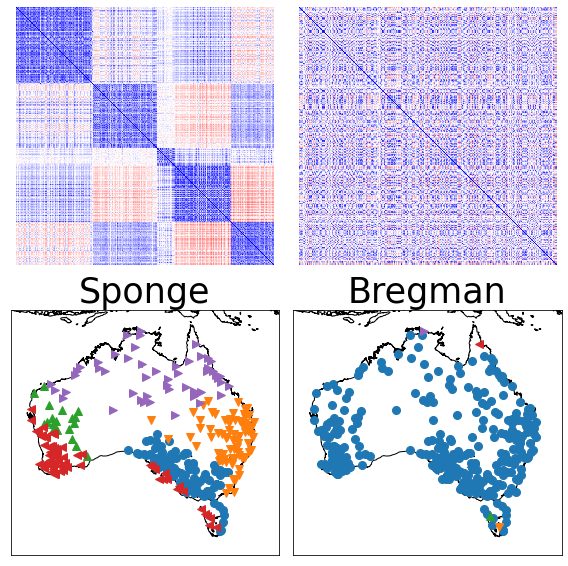

In [19]:
fig, axs = plt.subplots(2, 2,figsize=(8, 8))
axs[0, 0].matshow(ssortedp-ssortedn,cmap='bwr_r',vmin=-1,vmax=1)
axs[0, 0].axis('off')
axs[0, 1].matshow(ssortedp2-ssortedn2,cmap='bwr_r',vmin=-1,vmax=1)
axs[0, 1].axis('off')

#Second line
axs[1, 0].set_title("Sponge",fontsize=35)
grouped_coords = []
for i in range(k):
    i_stations = stations_a[predictions==i]
    i_coords = []
    for s in i_stations:
        idx = np.where(stat_lat_lon_a[:,0] == s)
        i_coords.append(stat_lat_lon_a[idx])
    grouped_coords.append(i_coords)
mm = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
            llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i',ax=axs[1,0])
# Draw coastlines and fill continents and water with color
mm.drawcoastlines()
colors = ['r', 'g', 'b', 'c', 'y']
markers = []
for i in range(k):
    coords = np.array(grouped_coords[i])[:, 0, 1:3]
    x,y = mm(coords[:,1],coords[:,0])
    mm.plot(x,y, color = cmap(i), markersize=8, lw = 0, marker = markers_[i])
    
axs[1, 1].set_title('Bregman',fontsize=35)
grouped_coords = []
for i in range(k):
    i_stations = stations_a[predictions2==i]
    i_coords = []
    for s in i_stations:
        idx = np.where(stat_lat_lon_a[:,0] == s)
        i_coords.append(stat_lat_lon_a[idx])
    grouped_coords.append(i_coords)
    
mm = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
            llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i',ax=axs[1,1])

# Draw coastlines and fill continents and water with color
mm.drawcoastlines()
colors = ['r', 'g', 'b', 'c', 'y']
markers = []
for i in range(k):
    coords = np.array(grouped_coords[i])[:, 0, 1:3]
    x,y = mm(coords[:,1],coords[:,0])
    mm.plot(x,y, color = cmap(i), markersize=8, lw = 0, marker = markers_[i])

plt.tight_layout()

In [20]:
rand_score(predictions, predictions2),mutual_info_score(predictions,predictions2)

(0.24510875388406728, 0.021682543498257288)

## Equally spaced distributions

In [21]:
pin=0.1
#pouts = np.arange(pout_min,pout_max,0.01)
pouts=[0.01,0.05,0.1]
sigmas=[0.1,1,10]
with open("metrics.txt",'w',encoding = 'utf-8') as f:
    f.write("pout,sigma,RandIndexBregman,StdRandBregman,MutualInfoBregman,StdMutualBregman,\
    RandIndexKmeans,StdRandKmeans,MutualInfoKmeans,StdMutualKmeans,\
    RandIndexSpectral,StdRandSpectral,MutualInfoSpectral,StdMutualSpectral\n")
    for p_net in pouts:
        P_net = np.eye(3)*pin
        P_net[P_net==0] = p_net
        for sigma in sigmas:
            rs_b = []
            mi_b = []
            rs_k = []
            mi_k = []
            rs_s = []
            mi_s = []
            print(sigma,p_net)
            for _ in range(1):
                G,A,X = generate_benchmark_unit_circle(P_net,c,sigma,n,dim,delta=1)
                x_min = X.min()
                x_max = X.max()
                X = (X - x_min)/(x_max - x_min)
                pred_labels = KMeans(n_clusters=c).fit_predict(X)
                rs_k.append(rand_score(true_labels, pred_labels))
                mi_k.append(mutual_info_score(true_labels, pred_labels))
                
                pred_labels = spectral(A,c)
                rs_s.append(rand_score(true_labels, pred_labels))
                mi_s.append(mutual_info_score(true_labels, pred_labels))
                
#                 A = torch.tensor(A,dtype=torch.float32)
#                 X = torch.tensor(X,dtype=torch.float32)
                classifier = BregmanClustering(norm=-2,matrix_norm=False,method=method,
                                               data_divergence_method=data_divergence_method,
                                               net_divergence_method=net_divergence_method,
                                               initialization=initialization,
                                               data_divergence="euclidean",
                                               net_divergence="euclidean")
                W,B,mu=classifier.cluster(A,X,c,maxiter=100,threshold=5,annealing=False)
                print("====Pred mu\n",mu)
                pred_labels = np.argmax(W, axis=1)
                rs_b.append(rand_score(true_labels, pred_labels))
                mi_b.append(mutual_info_score(true_labels, pred_labels))
            f.write(f"{p_net},{sigma},{np.mean(rs_b)},{np.std(rs_b)},{np.mean(mi_b)},{np.std(mi_b)}\
            ,{np.mean(rs_k)},{np.std(rs_k)},{np.mean(mi_k)},{np.std(mi_k)}\
            ,{np.mean(rs_s)},{np.std(rs_s)},{np.mean(mi_s)},{np.std(mi_s)}\n")

0.1 0.01
net_div =  tensor(0.3269) data_div =  tensor(4.5428)
point assignments have converged
net_div =  tensor(0.3242) data_div =  tensor(21.5906)
====Pred mu
 [[0.42 0.42]
 [0.46 0.44]
 [0.43 0.45]]
1 0.01
net_div =  tensor(0.3269) data_div =  tensor(13.0908)
point assignments have converged
net_div =  tensor(0.6934) data_div =  tensor(18.2262)
====Pred mu
 [[0.49 0.48]
 [0.51 0.49]
 [0.49 0.5 ]]
10 0.01
net_div =  tensor(0.3269) data_div =  tensor(13.1791)
point assignments have converged
net_div =  tensor(0.6828) data_div =  tensor(13.6787)
====Pred mu
 [[0.45 0.45]
 [0.45 0.45]
 [0.45 0.45]]
0.1 0.05
net_div =  tensor(16.5656) data_div =  tensor(29.9785)
point assignments have converged
net_div =  tensor(0.7235) data_div =  tensor(26.6756)
====Pred mu
 [[0.46 0.45]
 [0.45 0.42]
 [0.42 0.48]]
1 0.05
net_div =  tensor(16.5656) data_div =  tensor(17.3285)
point assignments have converged
net_div =  tensor(0.7883) data_div =  tensor(16.5576)
====Pred mu
 [[0.44 0.42]
 [0.43 0.44]
 [0

In [22]:
df = pd.read_csv("metrics.txt")
df

,pout,sigma,RandIndexBregman,StdRandBregman,MutualInfoBregman,StdMutualBregman,RandIndexKmeans,StdRandKmeans,MutualInfoKmeans,StdMutualKmeans,RandIndexSpectral,StdRandSpectral,MutualInfoSpectral,StdMutualSpectral
0,0.01,0.1,1.000000,0.0,1.098612,0.0,1.000000,0.0,1.098612,0.0,0.995563,0.0,1.079912,0.0
1,0.01,1.0,0.742207,0.0,0.398477,0.0,0.674002,0.0,0.261336,0.0,0.991104,0.0,1.061178,0.0
2,0.01,10.0,0.697414,0.0,0.300816,0.0,0.567202,0.0,0.031957,0.0,0.995563,0.0,1.079912,0.0
3,0.05,0.1,0.766533,0.0,0.620463,0.0,0.991148,0.0,1.061211,0.0,0.335585,0.0,0.007335,0.0
4,0.05,1.0,0.566800,0.0,0.152648,0.0,0.665084,0.0,0.241162,0.0,0.335585,0.0,0.007335,0.0
5,0.05,10.0,0.554381,0.0,0.030034,0.0,0.560513,0.0,0.019629,0.0,0.335585,0.0,0.007335,0.0
6,0.10,0.1,0.879509,0.0,0.809781,0.0,0.995563,0.0,1.079912,0.0,0.335585,0.0,0.007335,0.0
7,0.10,1.0,0.663790,0.0,0.296930,0.0,0.702207,0.0,0.334355,0.0,0.335585,0.0,0.007335,0.0
8,0.10,10.0,0.546644,0.0,0.023191,0.0,0.569231,0.0,0.033687,0.0,0.335585,0.0,0.007335,0.0


In [23]:
pin=0.1
#pouts = np.arange(pout_min,pout_max,0.01)
pouts=[0.01,0.05,0.1]
deltas=[0.01,1,10]
with open("metrics_Delta.txt",'w',encoding = 'utf-8') as f:
    f.write("pout,delta,RandIndexBregman,StdRandBregman,MutualInfoBregman,StdMutualBregman,\
    RandIndexKmeans,StdRandKmeans,MutualInfoKmeans,StdMutualKmeans,\
    RandIndexSpectral,StdRandSpectral,MutualInfoSpectral,StdMutualSpectral\n")
    for p_net in pouts:
        P_net = np.eye(3)*pin
        P_net[P_net==0] = p_net
        for delta in deltas:
            rs_b = []
            mi_b = []
            rs_k = []
            mi_k = []
            rs_s = []
            mi_s = []
            print(delta,p_net)
            for _ in range(1):
                G,A,X = generate_benchmark_unit_circle(P_net,c,1,n,dim,delta)
                x_min = X.min()
                x_max = X.max()
                X = (X - x_min)/(x_max - x_min)
                pred_labels = KMeans(n_clusters=c).fit_predict(X)
                rs_k.append(rand_score(true_labels, pred_labels))
                mi_k.append(mutual_info_score(true_labels, pred_labels))
                
                pred_labels = spectral(A,c)
                rs_s.append(rand_score(true_labels, pred_labels))
                mi_s.append(mutual_info_score(true_labels, pred_labels))
                
#                 A = torch.tensor(A,dtype=torch.float32)
#                 X = torch.tensor(X,dtype=torch.float32)
                classifier = BregmanClustering(norm=-2,matrix_norm=False,method=method,
                                               net_divergence_method=net_divergence_method,
                                               initialization=initialization,
                                               data_divergence="euclidean",
                                               net_divergence="euclidean")
                W,B,mu=classifier.cluster(A,X,c,maxiter=100,threshold=5)
                print("====Pred mu\n",mu)
                pred_labels = np.argmax(W, axis=1)
                rs_b.append(rand_score(true_labels, pred_labels))
                mi_b.append(mutual_info_score(true_labels, pred_labels))
            f.write(f"{p_net},{delta},{np.mean(rs_b)},{np.std(rs_b)},{np.mean(mi_b)},{np.std(mi_b)}\
            ,{np.mean(rs_k)},{np.std(rs_k)},{np.mean(mi_k)},{np.std(mi_k)}\
            ,{np.mean(rs_s)},{np.std(rs_s)},{np.mean(mi_s)},{np.std(mi_s)}\n")

0.01 0.01
net_div =  tensor(0.3269) data_div =  tensor(9.7660)
point assignments have converged
net_div =  tensor(0.5366) data_div =  tensor(9.9472)
====Pred mu
 [[0.63 0.64]
 [0.63 0.64]
 [0.63 0.64]]
1 0.01
net_div =  tensor(0.3269) data_div =  tensor(13.0259)
point assignments have converged
net_div =  tensor(0.7017) data_div =  tensor(18.5447)
====Pred mu
 [[0.49 0.5 ]
 [0.5  0.5 ]
 [0.49 0.51]]
10 0.01
net_div =  tensor(0.3269) data_div =  tensor(1.5671)
point assignments have converged
net_div =  tensor(0.3242) data_div =  tensor(33.7321)
====Pred mu
 [[0.45 0.55]
 [0.56 0.49]
 [0.45 0.42]]
0.01 0.05
net_div =  tensor(16.5656) data_div =  tensor(14.8427)
point assignments have converged
net_div =  tensor(0.6349) data_div =  tensor(14.4692)
====Pred mu
 [[0.5  0.49]
 [0.51 0.51]
 [0.5  0.49]]
1 0.05
net_div =  tensor(16.5656) data_div =  tensor(17.5450)
point assignments have converged
net_div =  tensor(0.6525) data_div =  tensor(16.9805)
====Pred mu
 [[0.49 0.48]
 [0.48 0.47]
 [0

In [24]:
df = pd.read_csv("metrics_Delta.txt")
df

,pout,delta,RandIndexBregman,StdRandBregman,MutualInfoBregman,StdMutualBregman,RandIndexKmeans,StdRandKmeans,MutualInfoKmeans,StdMutualKmeans,RandIndexSpectral,StdRandSpectral,MutualInfoSpectral,StdMutualSpectral
0,0.01,0.01,0.866109,0.0,0.737202,0.0,0.550769,0.0,0.002989,0.0,0.995563,0.0,1.079912,0.0
1,0.01,1.00,0.753066,0.0,0.420243,0.0,0.674404,0.0,0.261113,0.0,0.995563,0.0,1.079912,0.0
2,0.01,10.00,1.000000,0.0,1.098612,0.0,1.000000,0.0,1.098612,0.0,0.995563,0.0,1.079912,0.0
3,0.05,0.01,0.534426,0.0,0.001351,0.0,0.557369,0.0,0.007479,0.0,0.335585,0.0,0.007335,0.0
4,0.05,1.00,0.672085,0.0,0.256420,0.0,0.691394,0.0,0.311785,0.0,0.335585,0.0,0.007335,0.0
5,0.05,10.00,1.000000,0.0,1.098612,0.0,1.000000,0.0,1.098612,0.0,0.335585,0.0,0.007335,0.0
6,0.10,0.01,0.540870,0.0,0.012160,0.0,0.559175,0.0,0.011764,0.0,0.335585,0.0,0.007335,0.0
7,0.10,1.00,0.455987,0.0,0.084721,0.0,0.686444,0.0,0.290289,0.0,0.335585,0.0,0.007335,0.0
8,0.10,10.00,0.991171,0.0,1.065799,0.0,1.000000,0.0,1.098612,0.0,0.335585,0.0,0.007335,0.0
